In [1]:
from pyspark import SparkContext
from pyspark.mllib.recommendation import *
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [4]:
# works for both python 2 and 3
import csv
rddRatings = sc.textFile("jester_ratings.csv")
rddJokes = sc.textFile("jester_items.csv")


print(rddRatings.first())
print(rddJokes.first())

rddRatings = rddRatings.mapPartitions(lambda x: csv.reader(x,delimiter = ','))
rddJokes = rddJokes.mapPartitions(lambda x: csv.reader(x,delimiter = ','))


userId,jokeId,rating
jokeId,jokeText


In [5]:
def remove_header(itr_index, itr):
    return iter(list(itr)[1:]) if itr_index == 0 else itr

In [6]:
rddRatings = rddRatings.mapPartitionsWithIndex(remove_header)
rddJokes = rddJokes.mapPartitionsWithIndex(remove_header)

In [7]:
rddRatings.first()

['1', '5', '0.21899999999999997']

In [8]:
rddJokes.first()

['1',
 'A man visits the doctor. The doctor says "I have bad news for you.You havecancer and Alzheimer\'s disease". The man replies "Well,thank God I don\'t have cancer!"']

In [9]:
userCount = rddRatings.map(lambda line : line[0]).distinct().count()
print(userCount)

59132


In [10]:
ratingswithjoke = rddRatings.map(lambda x : [x[1],x[2]])
ratingsDict = {}
for (joke,rating) in ratingswithjoke.collect():
        if joke in ratingsDict.keys():
            ratingsDict[joke] += float(rating)
        else:
            ratingsDict[joke] = float(rating)
result = sorted(ratingsDict.items(), key = lambda kv:(kv[1], kv[0]),reverse = True)

In [11]:
top_10Jokes = {key:value for (key,value) in result[:10]}

In [12]:
top_10Jokes

{'89': 93754.72199999956,
 '53': 85809.62800000027,
 '114': 81933.6129999999,
 '105': 80986.30599999962,
 '32': 78923.22599999953,
 '106': 74279.02499999982,
 '35': 73071.69500000021,
 '129': 69910.42099999994,
 '72': 68084.43900000007,
 '104': 67747.41099999986}

In [13]:
import matplotlib.pyplot as plt

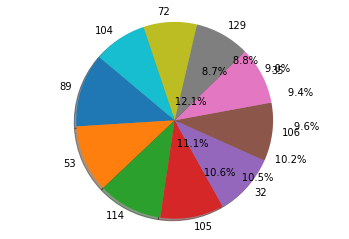

In [14]:
# Data to plot
labels = top_10Jokes.keys()
sizes = top_10Jokes.values()

# Plot
plt.pie(sizes,  labels=labels,autopct='%50.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

<BarContainer object of 641 artists>

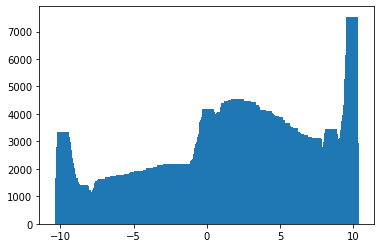

In [15]:
ratings = rddRatings.map(lambda line : float(line[2]))
rat_dict = {}
for rat in ratings.collect():
    if rat in rat_dict.keys():
        rat_dict[rat] += 1
    else:
        rat_dict[rat] = 1
barChartLabels, barChartValues = zip(*rat_dict.items())
plt.bar(barChartLabels, barChartValues)

In [16]:
rddRatings = rddRatings.map(lambda line : Rating(int(line[0]),int(line[1]),float(line[2])),preservesPartitioning=True)
ratings_df = spark.createDataFrame((rddRatings),
    ("userId", "jokeId", "rating"))

jokes_df = spark.createDataFrame((rddJokes),
    ("jokeId", "text"))

In [17]:
X_train, X_test = ratings_df.randomSplit([0.7,0.3],seed = 5041)

In [18]:
print("Training data size : ", X_train.count())
print("Test data size : ", X_test.count())

Training data size :  1232777
Test data size :  528662


In [19]:
X_train.show(5)

+------+------+------+
|userId|jokeId|rating|
+------+------+------+
|     1|     7|-9.281|
|     1|     8|-9.281|
|     1|    15| 0.875|
|     1|    16|-9.656|
|     1|    17|-9.031|
+------+------+------+
only showing top 5 rows



In [20]:
X_test.show(5)

+------+------+-------------------+
|userId|jokeId|             rating|
+------+------+-------------------+
|     1|     5|0.21899999999999997|
|     1|    13| -6.781000000000001|
|     1|    22|             -8.781|
|     1|    24| -7.906000000000001|
|     1|    27|              8.781|
+------+------+-------------------+
only showing top 5 rows



In [20]:
from pyspark.ml.recommendation import ALS    
import numpy as np
def trainModelAndCalcMseValue(rank,iter_num,alpha_val):
    als = ALS(userCol="userId",itemCol="jokeId",ratingCol="rating",rank=rank, maxIter=iter_num,alpha = alpha_val, seed=5041)
    model = als.fit(X_train)
    predictions = model.transform(X_test[["userId","jokeId"]])  
    ratesAndPreds = X_test.join(other=predictions,on=['userId','jokeId'],how='inner').na.drop() 
    rating = np.array(ratesAndPreds.select("rating").collect()).ravel()
    prediction = np.array(ratesAndPreds.select("prediction").collect()).ravel()
    print(f"Rank : {rank} - Iterations : {iter_num} - Alpha(Lambda) : {alpha_val} ")
    print("MSE : ", np.mean((rating - prediction)**2))

In [21]:
trainModelAndCalcMseValue(10,10,0.1)

Rank : 10 - Iterations : 10 - Alpha(Lambda) : 0.1 
MSE :  20.3934156829641
